<a href="https://colab.research.google.com/github/rishabhshah13/Adversarial_Patch_XAI590/blob/main/Assignment%205/Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 5 - Explainable Technique


## Rishabh Shah:

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models, transforms
from PIL import Image
from lime import lime_image
from skimage.segmentation import mark_boundaries
from alibi.explainers import AnchorImage
import cv2


In [2]:
!wget https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01532829_house_finch.JPEG -O /content/sample_image.jpg

--2024-10-03 07:01:40--  https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01532829_house_finch.JPEG
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78014 (76K) [image/jpeg]
Saving to: ‘/content/sample_image.jpg’

/content/sample_ima 100%[===================>]  76.19K  --.-KB/s    in 0.01s   

2024-10-03 07:01:40 (5.46 MB/s) - ‘/content/sample_image.jpg’ saved [78014/78014]



In [3]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O /content/imagenet_classes.txt

--2024-10-03 07:01:40--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘/content/imagenet_classes.txt’

/content/imagenet_c 100%[===================>]  10.23K  --.-KB/s    in 0.001s  

2024-10-03 07:01:41 (14.0 MB/s) - ‘/content/imagenet_classes.txt’ saved [10472/10472]



# 1. Dataset and Model Preparation

In this section, we download and prepare a pre-trained ResNet34 model, along with defining the necessary image transformations. We also load a sample image to test our model.


In [4]:
# Download and load a pre-trained ResNet34 model
model = models.resnet34(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Define image transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize(256),  # Resize to 256 pixels
    transforms.CenterCrop(224),  # Center crop to 224 pixels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats
])

# Load an example image (replace with your image path)
image_path = "sample_image.jpg"  # Example path, replace with your image
pil_image = Image.open(image_path).convert("RGB")  # Load and convert image to RGB
image_tensor = transform(pil_image).unsqueeze(0)  # Apply transformations and add batch dimension

# Get the model's prediction
with torch.no_grad():
    output = model(image_tensor)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)  # Apply softmax to get probabilities
    predicted_class = torch.argmax(probabilities)  # Get the predicted class index


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 2. LIME Implementation

## LIME (Local Interpretable Model-agnostic Explanations)

### Chosen Technique
I chose LIME for generating local explanations of predictions from the ResNet34 model. LIME approximates the model's behavior around a specific input instance by perturbing the input and analyzing the impact on predictions.

### Explanation of LIME
LIME generates explanations by creating a locally interpretable model that highlights influential features in the input image for the model's decision.

### Strengths
- **Model-Agnostic**: Applicable to any machine learning model.
- **Local Interpretability**: Provides specific explanations for individual predictions.
- **Clear Visualizations**: Intuitive visual output highlighting key features.

### Limitations
- **Computationally Intensive**: Requires substantial resources for perturbation sampling.
- **Potential Noise**: Explanations can be inconsistent for complex models.
- **Dependence on Perturbations**: Quality of explanations relies on the perturbation method.

### Potential Improvements
- **Increase Sample Size**: More perturbations can lead to more stable explanations.
- **Explore Alternative Perturbations**: Using different methods may enhance insights.
- **Combine with Other Techniques**: Pairing LIME with Grad-CAM or Anchors can provide a fuller understanding.

In [5]:
# Initialize the LIME explainer
explainer = lime_image.LimeImageExplainer()

def predict_fn(images):
    """Prediction function for LIME. Takes a list of numpy arrays (images) and returns predictions."""
    transformed_images = torch.stack([transform(Image.fromarray(img.astype('uint8'))) for img in images])
    with torch.no_grad():
        outputs = model(transformed_images)
        probs = torch.nn.functional.softmax(outputs, dim=1).numpy()  # Get probabilities
    return probs

# Generate explanations using LIME
explanation = explainer.explain_instance(np.array(pil_image),
                                         predict_fn,
                                         top_labels=5,  # Top 5 labels
                                         hide_color=0,
                                         num_samples=1000)  # Consider increasing num_samples for better explanations


  0%|          | 0/1000 [00:00<?, ?it/s]

# 3. Visualization

This section visualizes the explanations generated by LIME, showcasing which features of the image contributed positively or negatively to the predicted class.

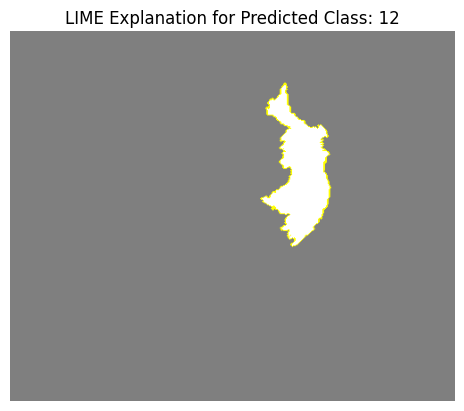

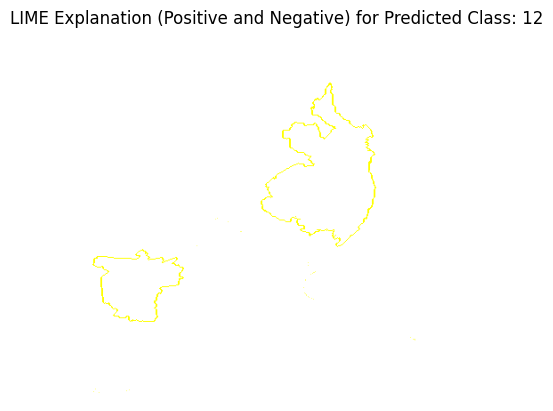

In [6]:
# Visualize the LIME explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))  # Use mark_boundaries for better visualization
plt.title(f"LIME Explanation for Predicted Class: {predicted_class.item()}")
plt.axis('off')  # Turn off axis
plt.show()

# Visualize positive and negative features
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f"LIME Explanation (Positive and Negative) for Predicted Class: {predicted_class.item()}")
plt.axis('off')  # Turn off axis
plt.show()


# 4. Anchor Image Implementation

## Anchor Explanations

### Chosen Technique
I selected Anchor explanations for this assignment to provide local insights into the predictions of the ResNet34 model. Anchor explanations are designed to identify feature subsets that lead to specific model predictions with high precision.

### Explanation of Anchor
Anchor explanations work by determining which parts of the input contribute most to the model's decision. They create "anchors"—sets of features that ensure the model's prediction remains consistent, even if other features change.

### Strengths
- **High Precision**: Anchors provide strong guarantees on the reliability of the explanations.
- **Local Interpretability**: Offers insights tailored to specific instances, enhancing understanding of model behavior.
- **Flexible**: Can be applied to various models and data types.

### Limitations
- **Dependency on Background Data**: Performance can be affected by the choice of background images used in segmentation.
- **Computationally Intensive**: May require considerable computation for large datasets or complex models.
- **Less Global Insight**: Primarily focuses on local explanations, which may limit understanding of overall model behavior.

### Potential Improvements
- **Optimize Background Selection**: Using a more representative background dataset can enhance the quality of the explanations.
- **Increase Computational Efficiency**: Implementing parallel processing techniques may speed up the explanation generation.
- **Combine with Other Methods**: Integrating Anchor explanations with LIME or Grad-CAM can provide a more holistic view of the model's decision-making process.


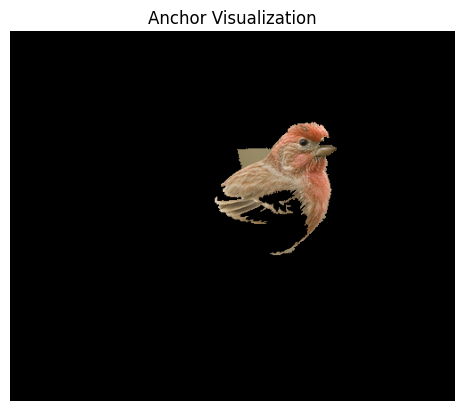

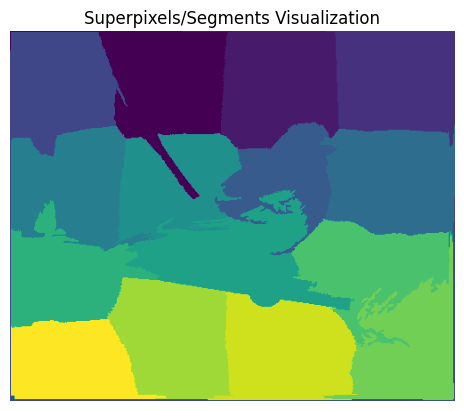

In [7]:
# Initialize the AnchorImage explainer
segmentation_fn = 'slic'
kwargs = {'n_segments': 15, 'compactness': 20, 'sigma': .5}  # Adjust segmentation parameters as needed
explainer = AnchorImage(predict_fn, image_shape=(224, 224, 3), segmentation_fn=segmentation_fn,
                        segmentation_kwargs=kwargs)

# Explain the prediction for the input image (provide the image as a numpy array)
np_image = np.array(pil_image)
explanation = explainer.explain(np_image, threshold=0.95)

# Visualize the anchor
plt.imshow(explanation.anchor)
plt.title("Anchor Visualization")
plt.axis('off')  # Turn off axis
plt.show()

# Visualize the superpixels
plt.imshow(explanation.segments)
plt.title("Superpixels/Segments Visualization")
plt.axis('off')  # Turn off axis
plt.show()

# 5. Grad-CAM Implementation

### Chosen Technique
I opted for Grad-CAM to visualize the regions of the input image that contribute most to the predictions made by the ResNet34 model. Grad-CAM uses gradients of the output with respect to the feature maps of the last convolutional layer to highlight important areas.

### Explanation of Grad-CAM
Grad-CAM generates a heatmap that indicates the most relevant parts of an image for a given prediction. By backpropagating the gradients from the target class through the model, it identifies which features had the most significant influence on the model's decision.

### Strengths
- **Intuitive Visualizations**: Provides clear and interpretable visual heatmaps that highlight important image regions.
- **Model-Agnostic**: Can be applied to any convolutional neural network (CNN), regardless of architecture.
- **Supports Fine-tuning**: Grad-CAM can help in understanding how to improve the model by analyzing misclassifications.

### Limitations
- **Dependence on Gradients**: The quality of explanations relies heavily on the gradient flow, which can sometimes lead to noisy visualizations.
- **Limited to CNNs**: Primarily applicable to convolutional models; less effective for non-CNN architectures.
- **Smoothing of Features**: May produce less precise results on images with fine details or subtle features.

### Potential Improvements
- **Refine Activation Maps**: Implementing techniques like guided backpropagation can enhance the granularity of the heatmaps.
- **Combine with Other Techniques**: Using Grad-CAM alongside methods like LIME or Anchors may provide complementary insights into model behavior.
- **Optimize Computational Efficiency**: Employing faster gradient computation methods can reduce the time taken for generating heatmaps.


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


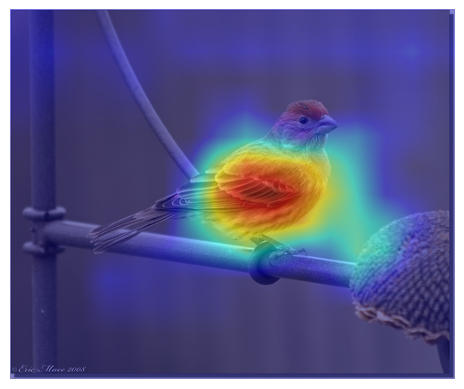

In [8]:
import torch
from torchvision.models import resnet34
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.transforms import Compose, Normalize, ToTensor
from PIL import Image
import numpy as np

# Load pre-trained ResNet34 model
model = resnet34(pretrained=True)
model.eval()

# Define target layers (usually the last convolutional layer)
target_layers = [model.layer4[-1]]

# Load and preprocess the image
image_path = "sample_image.jpg"
image = Image.open(image_path).convert('RGB')
preprocess = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(image).unsqueeze(0)

cam = GradCAM(model=model, target_layers=target_layers)


# Define the target (e.g., class index 281 for 'tabby cat' in ImageNet)
targets = [ClassifierOutputTarget(281)]

# Generate the CAM
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# Visualize the result
rgb_img = np.array(image)
visualization = show_cam_on_image(rgb_img/255.0, grayscale_cam[0], use_rgb=True)

# Display or save the visualization
import matplotlib.pyplot as plt
plt.imshow(visualization)
plt.axis('off')
plt.show()




## Discussion on Explanation Techniques
- **Chosen Technique**: LIME was chosen for its ability to provide local interpretability by approximating the model locally.
- **Strengths**: It is model-agnostic and can handle any black-box model. It provides clear visualizations.
- **Limitations**: The need to sample many perturbations can be computationally expensive and may lead to noisy explanations.
- **Potential Improvements**: Increase the number of samples for LIME and explore different segmentation techniques for Anchor Image.



| **Technique** | **Description** | **Key Features** |
|---------------|------------------|-------------------|
| **LIME**      | Local Interpretable Model-agnostic Explanations | - Perturbation-based method generating local explanations.<br>- Provides interpretable linear models locally around the prediction.<br>- Applicable to any model. |
| **Anchors**   | Model-Agnostic Explanations via Prototypes | - Uses a perturbation approach to find decision rules (anchors) that yield stable predictions.<br>- Offers high-precision and intuitive explanations.<br>- Guarantees that the explanation will hold for a range of input perturbations. |
| **Grad-CAM**  | Gradient-weighted Class Activation Mapping | - Uses gradients from the final layer to produce heatmaps over input images.<br>- Provides visual explanations for deep learning models, especially CNNs.<br>- Focuses on spatial importance rather than local feature relevance. |


---

